<a href="https://colab.research.google.com/github/ragabhumi/Pelatihan_Earth_Imaging/blob/main/Workshop_Pengolahan_Data_Magnetik_dari_Satelit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**WORKSHOP PENGOLAHAN DATA MAGNETIK DARI SATELIT**

**Pemodelan Magnet Bumi menggunakan Data Model Global EMAG2v3**

oleh: Yosi Setiawan

8 Juli 2023

Workshop ini bertujuan untuk memberikan pemahaman dan keahlian dalam melakukan analisis & interpretasi kondisi bawah permukaan bumi menggunakan metode magnet bumi dan aplikasinya dengan memanfaatkan data model global yang tersedia.

Pada praktik pengolahan data magnet bumi ini, software yang digunakan adalah Fatiando a Terra (Uieda et.al., 2013) untuk analisis data magnet bumi, dan PyGMT (Uieda et.al., 2023) untuk visualisasi yang keduanya berbasis Python. Pengolahan dilakukan di Google Colab untuk memudahkan akses terhadap program dan data yang digunakan tanpa harus menginstall di komputer atau laptop masing-masing peserta.

Pada bagian ini, data yang akan digunakan adalah **data model magnet bumi EMAG2v3**.

Langkah pertama yang harus dilakukan adalah menginstal CondaColab di Google Colab di akun Google masing-masing. Tekan tombol **Run cell** di sebelah kiri setiap cell atau tekan tombol Ctrl+Enter. Tunggu hingga proses instalasi selesai. Jika muncul notifikasi **Your session crashed for an unknown reason.**, abaikan dan tutup notifikasi tersebut.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Selanjutnya, cek apakah instalasi CondaColab telah berhasil. Pastikan hasil yang muncul adalah **Everything looks OK!**.

In [ ]:
import condacolab
condacolab.check()

Langkah berikutnya adalah menginstal modul-modul Python yang diperlukan. Proses ini memerlukan waktu yang agak lama. Tunggulah hingga proses selesai.

In [ ]:
!mamba install verde harmonica boule pooch pygmt pyproj pandas xarray xrft ensaio pyproj rioxarray

Import modul-modul Python yang akan digunakan

In [ ]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xrft
import datetime
from scipy import signal

# For projections (wrapped for Proj)
import pyproj

# Plotting maps using GMT
import pygmt

# The Fatiando stack
import pooch
import verde as vd
import boule as bl
import harmonica as hm

Data magnet bumi yang akan digunakan dalam workshop ini telah diupload di Github. Untuk mengunduhnya kita gunakan modul Pooch.

In [ ]:
url_mag = 'https://raw.githubusercontent.com/ragabhumi/Pelatihan_Earth_Imaging/main/data/EMAG2v3_area1.csv'
path_mag = pooch.retrieve(url_mag, known_hash=None)
print(path_mag)

Selanjutnya, data model magnet bumi dengan format csv kita parsing menggunakan modul Pandas dan diberikan nama untuk setiap kolomnya.

In [ ]:
data = pd.read_csv(path_mag, sep=' ', names=['i', 'j', 'Longitude', 'Latitude', 'Sealevel', 'UpCont', 'Code', 'Error'])
data

Pada data yang kita gunakan, terdapat beberapa titik yang datanya ambigu maupun titik yang tidak ada data. Titik yang datanya ambigu diberikan kode 888 dan nilainya -888 nT, sedangkan titik yang tidak ada data diberikan kode 999 dan nilainya 99999 nT. Sehingga titik-titik tersebut harus kita hilangkan.

In [ ]:
data = data[(data['Code'] != 888) & (data['Code'] != 999) & (data['Sealevel'] != 99999.0)]
data

Kita tampilkan lokasi data kita.

In [ ]:
fig = pygmt.Figure()
fig.basemap(projection='M15', region=[90, 145, -12, 10], frame=True)
fig.coast(resolution='h', shorelines='0.5p,black,solid', water='lightblue')
fig.plot(x=data['Longitude'], y=data['Latitude'],
    style="c0.1c",
    fill="red",
    pen="faint")
fig.show()

Kita tampilkan titik-titik grid model magnet.

In [ ]:
# Kita atur batas koordinat sesuai dengan batasan data kita
lon_min = data['Longitude'].min()
lon_max = data['Longitude'].max()
lat_min = data['Latitude'].min()
lat_max = data['Latitude'].max()

fig = pygmt.Figure()
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.coast(resolution='f', shorelines='2p,black,solid', water='lightblue')
fig.plot(x=data['Longitude'], y=data['Latitude'],
    style="c0.1c",
    fill="red",
    pen="faint")
fig.show()

Menampilkan peta model anomali magnet bumi dalam bentuk kontur. Pertama, kita interpolasikan dahulu data txt menjadi data grid dan kita resampling menjadi 1 menit busur agar konturnya menjadi lebih halus. Data yang kita gunakan adalah data pada ketinggian sea level.

In [ ]:
pre_data = pygmt.blockmean(x=data['Longitude'], y=data['Latitude'], z=data['Sealevel'], region=[lon_min, lon_max, lat_min, lat_max], spacing='1m')
data_grid = pygmt.surface(pre_data, region=[lon_min, lon_max, lat_min, lat_max], spacing='1m')
data_grid

Kita tampilkan peta konturnya menggunakan PyGMT.

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[data_grid.min().values, data_grid.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=data_grid, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=data_grid, interval=50, annotation=50)

# Add colorbar
fig.colorbar(frame='af+l"Peta Intensitas Magnet Total (nT)"', position="JBC+h+o0/1c+e")
fig.show()

**1. Reduksi ke kutub**

Reduksi ke Kutub atau *Reduction to The Pole* (RTP) merupakan salah satu dari beberapa filter yang digunakan untuk membantu proses interpretasi. Filter RTP pada dasarnya mentransformasikan anomali magnetik disuatu lokasi ke kutub utara magnetik bumi. Sehingga, anomali medan magnet terletak tepat diatas tubuh benda penyebab anomali dan anomali magnet tidak lagi bersifat dipole/dua kutub tetapi menjadi bersifat monopole/satu kutub. Reduksi ke kutub dilakukan dengan dengan cara mengubah sudut inklinasi menjadi 90° dan deklinasi menjadi 0°.

Filter RTP mengasumsikan bahwa pada seluruh lokasi pengambilan data, nilai medan magnet bumi (terutama Inklinasi dan Deklinasi) memiliki nilai dan arah yang konstan. Asumsi ini dapat diterima apabila lokasi tersebut memiliki luas area yang relatif sempit. Namun asumsi ini tidak dapat digunakan apabila luas daerah pengambilan data sangat luas karena melibatkan nilai lintang dan bujur yang bervariasi, dimana harga medan magnet bumi berubah secara bertahap. Setelah dilakukan RTP, maka anomali yang muncul tidak lagi bersifat dipole, tetapi monopole sehingga lebih mudah untuk diidentifikasi.

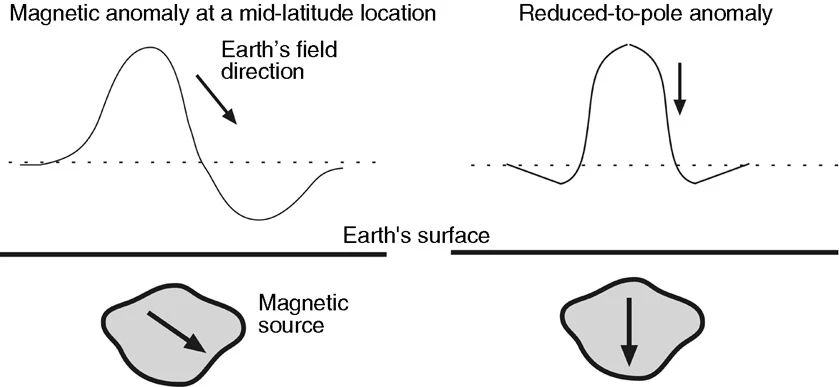

Gambar respon anomali magnetik di permukaan akibat sumber medan magnetik di bawah permukaan. (Kiri) Sebelum proses RTP, orientasi anomali masih searah dengan arah medan magnet bumi. (Kanan) Setelah proses RTP, orientasi anomali ke arah vertikal (Ravat, 2007).

Pada proses RTP, kita memerlukan rata-rata nilai deklinasi dan inklinasi di daerah penelitian kita. Nilai ini bisa didapatkan menggunakan model IGRF. Pada lokasi yang kita gunakan, nilai inklinasi rata-ratanya adalah -31.553° sedangkan deklinasi rata-ratanya adalah 0.636°.

Data anomali magnet bumi ini harus kita reduksi ke kutub sebelum dilakukan pemisahan anomali regional dan residual. Namun, proses reduksi ke kutub ini hanya dapat dilakukan pada sistem koordinat kartesian, sehingga data dalam sistem koordinat geografis harus kita proyeksikan ke sistem koordinat kartesian terlebih dahulu.

Kita definisikan dahulu proyeksinya mengunakan pyproj.

In [ ]:
CRS = pyproj.crs.CRS(proj="merc", lat_ts=data_grid.lat.mean().values)

Selanjutnya, kita konversi data dari sistem koordinat geografis ke sistem koordinat kartesian.

In [ ]:
data_grid.rio.write_crs('+proj=lonlat', inplace=True)
utm_grid = data_grid.rio.reproject(CRS)
utm_grid = utm_grid.rename({'x':'easting', 'y':'northing'})
utm_grid

Kita lakukan transformasi reduksi ke kutub untuk data sea level.

In [ ]:
# Pad the grid to increase accuracy of the FFT filter
pad_width = {
    "easting": utm_grid.easting.size // 3,
    "northing": utm_grid.northing.size // 3,
}

utm_grid_pad = xrft.pad(utm_grid, pad_width)

inclination, declination = -31.553, 0.636

rtp_grid = hm.reduction_to_pole(
    utm_grid_pad, inclination=inclination, declination=declination
)

# Unpad the reduced to the pole grid
rtp_grid = xrft.unpad(rtp_grid, pad_width)
rtp_grid

Data yang sudah ditransformasikan ke kutub dalam sistem koordinat kartesian kita proyeksikan kembali kedalam sistem koordinat geografis.

In [ ]:
rtp_grid.rio.write_crs(CRS, inplace=True)
rtp_grid.rio.set_spatial_dims("easting", "northing", inplace=True)
rtp_grid = rtp_grid.rio.reproject('+proj=latlon')
rtp_grid

Menampilkan peta anomali reduksi ke kutub untuk data sea level.

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[rtp_grid.min().values, rtp_grid.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=rtp_grid, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=rtp_grid, interval=100, annotation=100)

# Add colorbar
fig.colorbar(frame='af+l"Peta Reduksi ke Kutub (nT)"', position="JBC+h+o0/1c+e")
fig.show()

**2. Penentuan Anomali Regional**

Untuk mendapatkan anomali residual, kita buat dahulu model anomali regionalnya. Disini kita bisa menggunakan metode polinomial atau upward continuation. Kita akan coba menggunakan polinomial orde 2 dan upward continuation ke ketinggian 40 km.

**Polinomial orde 2**

In [ ]:
xv, yv = np.meshgrid(rtp_grid.x, rtp_grid.y, indexing='ij')
coordinates = (xv, yv)
trend = vd.Trend(degree=2).fit(coordinates, rtp_grid.values)

regional_pol = rtp_grid.copy()
regional_pol = regional_pol.rename('regional')
regional_pol.values = trend.predict(coordinates)
regional_pol

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[regional_pol.min().values, regional_pol.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=regional_pol, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=regional_pol, interval=20, annotation=20)

# Add colorbar
fig.colorbar(frame='af+l"Peta Anomali Medan Magnet Regional - Metode Polinomial Orde 2 (nT)"', position="JBC+h+o0/1c+e")
fig.show()

**Upward Continuation ke 10 km**



Kontinuasi ke atas atau *Upward Continuation* merupakan suatu proses untuk mengubah data pengukuran medan potensial yang telah dikoreksi dalam satu permukaan ke permukaan yang lebih tinggi dari permukaan ketika melakukan pengukuran hingga beberapa meter. Untuk penentuan ketinggiannya tergantung pada keinginan dalam melihat target yang prospek sehingga dapat terlihat lebih jelas tanpa tergabung dengan noise–noise yang ada atau pengaruh dari benda–benda dekat permukaan yang bersifat magnet sehingga membuat data agak sulit untuk dilihat prospeknya.

Pada pengolahan data geomagnetik, proses ini dapat berfungsi sebagai filter tapis rendah, yaitu untuk menghilangkan atau mereduksi efek magnetik lokal yang berasal dari berbagai sumber benda magnetik yang tersebar di permukaan topografi yang tidak terkait dengan survei. Proses pengangkatan tidak boleh terlalu tinggi, karena hal ini dapat mereduksi anomali magnetik lokal yang bersumber dari benda magnetik atau struktur geologi yang menjadi target survei magnetik ini. Kontinuasi ke atas dapat kita gunakan untuk membuat anomali regional.

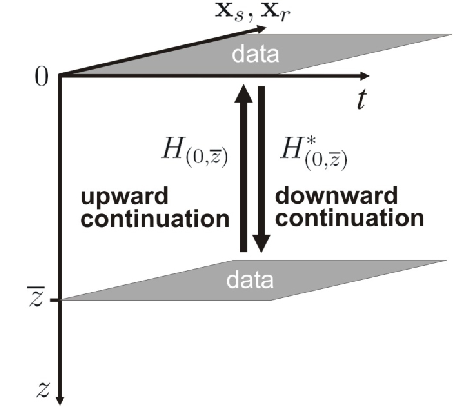

Gambar skema upward dan downward continuation dari suatu data di elevasi tertentu ke elevasi yang lain.

Untuk melakukan upward continuation, data yang sudah di RTP kan kita konversi terlebih dahulu dari sistem koordinat geografis ke sistem koordinat kartesian.

In [ ]:
utm_grid_rtp = rtp_grid.copy()
utm_grid_rtp = utm_grid_rtp.rio.reproject(CRS)
utm_grid_rtp = utm_grid_rtp.rename({'x':'easting', 'y':'northing'})
utm_grid_rtp

Pada data ini, data kita kontinuasikan ke ketinggian 40 km.

In [ ]:
# Pad the grid to increase accuracy of the FFT filter
pad_width = {
    "easting": utm_grid_rtp.easting.size // 3,
    "northing": utm_grid_rtp.northing.size // 3,
}

magnetic_grid = xrft.pad(utm_grid_rtp, pad_width)

# Upward continue the magnetic grid
upward_continued = hm.upward_continuation(magnetic_grid, height_displacement=40000)

# Unpad the reduced to the pole grid
upward_continued = xrft.unpad(upward_continued, pad_width)

Kita konversikan kembali dari sistem koordinat kartesian menjadi sistem koordinat geografis.

In [ ]:
upward_continued.rio.write_crs(CRS, inplace=True)
upward_continued.rio.set_spatial_dims("easting", "northing", inplace=True)
upward_continued_geog = upward_continued.rio.reproject('+proj=latlon')
upward_continued_geog = upward_continued_geog.rename('regional')
upward_continued_geog['x'] = rtp_grid.x
upward_continued_geog['y'] = rtp_grid.y
upward_continued_geog

Kita tampilkan peta kontur medan magnet total dan peta hasil proses kontinuasi ke atas pada ketinggian 40 km.

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[upward_continued_geog.min().values, upward_continued_geog.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=upward_continued_geog, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=upward_continued_geog, interval=20, annotation=20)

# Add colorbar
fig.colorbar(frame='af+l"Peta Anomali Medan Magnet Regional - Metode Upward Continuation 40 km (nT)"', position="JBC+h+o0/1c+e")
fig.show()

**3. Pemisahan Anomali Regional dan Residual**

Nilai anomali yang dihasilkan dari proses RTP yang telah dilakukan sebelumnya merupakan gabungan dari anomali regional dan anomali residual. Tahap pemisahan kedua anomali tersebut sangat penting dilakukan dalam penafsiran data magnet bumi. Terdapat beberapa teknik yang dapat digunakan dalam pemisahan anomali magnet bumi, seperti Polynomial, Upward Continuation, Moving Average, Trend Surface Analysis, Butterworth Filter, dan metode yang lain. Penentuan anomali regional sangat penting karena dari anomali regional ini nantinya akan didapat nilai anomali residualnya.

In [ ]:
# Menggunakan data regional hasil polinomial orde 2
#residual = rtp_grid - regional_pol
# Menggunakan data regional hasil upward continuation ke ketinggian 40 km
residual = rtp_grid - upward_continued_geog
residual

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[residual.min().values, residual.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=residual, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=residual, interval=100, annotation=100)

# Add colorbar
fig.colorbar(frame='af+l"Peta Anomali Medan Magnet Residual (nT)"', position="JBC+h+o0/1c+e")
fig.show()

**4. First Horizontal Derivative**

Untuk mempertajam pola anomali magnetik dari peta anomali residual, diperlukan transformasi atau pengolahan data lanjutan. Proses penajaman anomali bertujuan untuk mendelineasi posisi anomali secara tepat dan juga untuk pemisahan anomali yang saling berdekatan. Salah satu metode transformasi yang dapat digunakan adalah FHD atau First Horizontal Derivative. Filter FHD dapat digunakan untuk menentukan lokasi batas kontak kontras suseptibilitas horizontal dari data magnetik.

First Horizontal Derivative (FHD) atau Turunan Mendatar Pertama mempunyai
nama lain yaitu Horizontal Gradient. FHD dari anomali magnetik yang disebabkan oleh suatu body cenderung untuk menunjukkan tepian dari body-nya tersebut. Jadi metode FHD dapat digunakan untuk menentukan lokasi
batas kontak kontras suseptibilitas horizontal magnetik.

Turunan horizontal data medan potensial dapat langsung dihitung karena
umumnya data diukur pada titik yang tersebar secara spasial (x, y). Turunan horizontal orde satu arah x dan arah ydapat dihitung melalui pendekatan berikut:

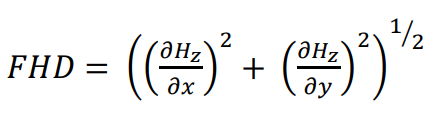

Sebelum melakukan transformasi FHD, data residual kita transformasikan dahulu ke sistem koordinat kartesian karena nilai FHD nantinya satuannya adalah nT/m.

In [ ]:
residual.rio.write_crs('+proj=lonlat', inplace=True)
utm_res = residual.rio.reproject(CRS)
utm_res = utm_res.rename({'x':'easting', 'y':'northing'})
utm_res

Setelah data ditransformasikan ke sistem koordinat kartesian, kita bisa menghitung nilai turunan orde pertama secara horizontal ke arah sumbu X dan sumbu Y.

In [ ]:
dx = hm.derivative_easting(utm_res, order=1)
dy = hm.derivative_northing(utm_res, order=1)

FHD = (dx**2 + dy**2)**0.5

Setelah didapatkan nilai FHD, data kita transformasikan kembali ke sistem koordinat geografis untuk dipetakan.

In [ ]:
FHD.rio.write_crs(CRS, inplace=True)
FHD.rio.set_spatial_dims("easting", "northing", inplace=True)
FHD = FHD.rio.reproject('+proj=latlon')
FHD

Kita petakan nilai FHD.

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[FHD.min().values, FHD.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=FHD, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=FHD, interval=0.01, annotation=0.01)

# Add colorbar
fig.colorbar(frame='af+l"Peta First Horizontal Derivative (nT/m)"', position="JBC+h+o0/1c+e")
fig.show()

**5. Second Vertical Derivative**

Selain FHD, metode SVD atau Second Vertical Derivative juga dapat digunakan untuk mendelineasi sumber anomali dan dapat memperjelas pola anomali dari data medan potensial. Second Vertical Derivative (SVD)
dilakukan untuk memunculkan efek dangkal dari pengaruh regionalnya dan
untuk menentukan batas-batas struktur yang ada di daerah penelitian, sehingga filter ini dapat menyelesaikan anomali residual yang tidak mampu dipisahkan dengan metode pemisahan regional-residual yang ada. Secara teoritis, metode ini diturunkan dari persamaan Laplace’s:

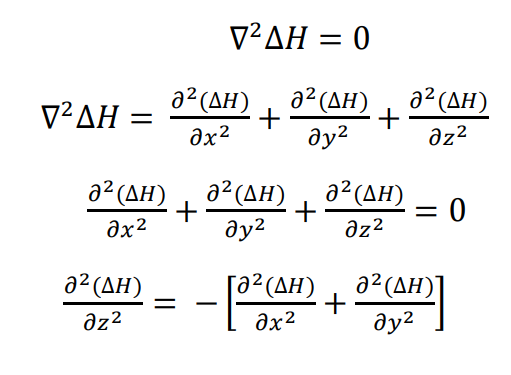

Berdasarkan persamaan diatas, dapat diketahui bahwa nilai SVD dari suatu anomali magnetik permukaan adalah sama dengan negatif dari derivative orde dua horizontalnya. SVD bersifat sebagai highpass filter, sehingga dapat menggambarkan anomali residual yang berasosiasi dengan struktur dangkal.

In [ ]:
dx2 = hm.derivative_easting(utm_res, order=2)
dy2 = hm.derivative_northing(utm_res, order=2)

SVD = -(dx2 + dy2)

Data SVD yang sudah dalam sistem koordinat kartesian kita konversikan ke sistem koordinat geografis untuk kemudian dipetakan.

In [ ]:
SVD.rio.write_crs(CRS, inplace=True)
SVD.rio.set_spatial_dims("easting", "northing", inplace=True)
SVD = SVD.rio.reproject('+proj=latlon')
SVD

Kita tampilkan peta SVD.

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[SVD.min().values, SVD.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=SVD, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=SVD, interval=0.001, annotation=0.001)

# Add colorbar
fig.colorbar(frame='af+l"Peta Second Vertical Derivative (nT/m@+2@+)"', position="JBC+h+o0/1c+e")
fig.show()

**Referensi**



> Arifin, Y. I. (2019). Kemagnetan Batuan (Anisotropi Batuan Beku). UNG Press Gorontalo.

> Constable, C.G., and Constable, S.C., (2004). Satellite magnetic field measurements: applications in studying the deep earth. In Sparks, R.S.J., and Hawkesworth, C.J., (eds.), The State of the Planet: Frontiers and Challenges in Geophysics. Washington, DC: American Geophysical Union, doi: 10.1029/150GM13, pp. 147–160.

> Fenoglio, M. A., Johnston, M.J.S., dan Byerlee, J.D. (1995). Magnetic and Electric Fields Associated with Changes in High Pore Pressure in Fault Zone-Application to the Loma Prieta ULF Emissions, J. Geophys. Res. 100, pp 12951-12958.

> Freund, F.T. (2007). Pre-Earthquake Signals-Part I: Deviatoric Stresses Turn Rocks into A Source of Electric Currents, Natural Hazards Earth System Science, pp 535-541.

> Hattori, K. (2004). ULF geomagnetic changes associated with large earthquakes, Terr. Atmos. OceanSci., vol. 15,no. 3, pp. 329–360.

> Ismaguilov, V. S., Kopytenko, Yu. A., Hattori, K., and Hayakawa, M. (2003). Variations of phase velocity and gradient values of ULF geomagnetic disturbances connected with the Izu strong earthquakes, Nat. Hazards Earth Syst. Sci., 3, 211–215, https://doi.org/10.5194/nhess-3-211-2003.

> Kolhatkar, A., Jamison, A., Litvinov, D., Willson, R., & Lee, T. (2013). Tuning the Magnetic Properties of Nanoparticles. International Journal of Molecular Sciences, 14(8), 15977–16009. MDPI AG. Retrieved from http://dx.doi.org/10.3390/ijms14081597

> Kopytenko, Y. & Ismagilov, V. & Hayakawa, Masashi & Smirnova, N. & Troyan, V. & Peterson, T.. (2001). Investigation of the ULF electromagnetic phenomena related to earthquakes: Contemporary achievements and the perspectives. Annali di Geofisica. 44. 325-334.

> Merzer, M., dan Klemperer, S.L. (1997). Modelling Low-Frequency Magnetik Field Prekursors to the Loma Prieta Earthquake with A Prekursory Increase in Fault Zone Conductivity, Pure Applied Geophysics, Vol. 150, pp 217-248.

> Molchanov, O.A., dan Hayakawa, M. (1998). On the Generation Mechanism of ULF Seismogenic Emissions, Physics Earth Planet International, Vol. 105, pp 210-210.

> Nettleton, L. L. (1962). Gravity and Magnetics for Geologists and Seismologists. AAPG Bulletin, Vol. 46, No. 10, pp. 1815-1838

> Ravat, D. (2007). Reduction to Pole. In: Gubbins, D., Herrero-Bervera, E. (eds) Encyclopedia of Geomagnetism and Paleomagnetism. Springer, Dordrecht. https://doi.org/10.1007/978-1-4020-4423-6_275

> Santosa, Bagus J., Mashuri, Sutrisno, Wahyu T., Wafi, A., Salim, R., dan Armi, R. (2012). Interpretasi Metode Magnetik untuk Penentuan Struktur Bawah Permukaan di Sekitar Gunung Kelud Kabupaten Kediri. Jurnal Penelitian Fisika dan Aplikasinya (JPFA), Vol. 2 No. 1, Juni 2012. ISSN: 2087-9946.

> Uieda, L., V. C. Oliveira Jr, and V. C. F. Barbosa (2013), Modeling the Earth with Fatiando a Terra, Proceedings of the 12th Python in Science Conference, pp. 91-98. doi:10.25080/Majora-8b375195-010

> Uieda, L., Tian, D., Leong, W. J., Schlitzer, W., Grund, M., Jones, M., Fröhlich, Y., Toney, L., Yao, J., Magen, Y., Tong, JH., Materna, K., Belem, A., Newton, T., Anant, A., Ziebarth, M., Quinn, J., and Wessel, P. (2023). PyGMT: A Python interface for the Generic Mapping Tools (Version 0.9.0). doi:10.5281/zenodo.7772533